In [ ]:
!pip install segment_anything
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from google.colab import files


In [ ]:
# Load SAM model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download SAM model checkpoint if not already downloaded
import os
try:
    os.system("wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth")
except:
    print("Failed to download SAM model checkpoint.")

# Specify the path to the checkpoint
checkpoint_path = "sam_vit_h_4b8939.pth"  # Ensure this file is in the same directory

sam = sam_model_registry["vit_h"](checkpoint=checkpoint_path).to(device)
mask_generator = SamAutomaticMaskGenerator(sam)


Saving Golden+Retrievers+dans+pet+care.jpeg to Golden+Retrievers+dans+pet+care (3).jpeg


Saving content.jpeg to content (2).jpeg


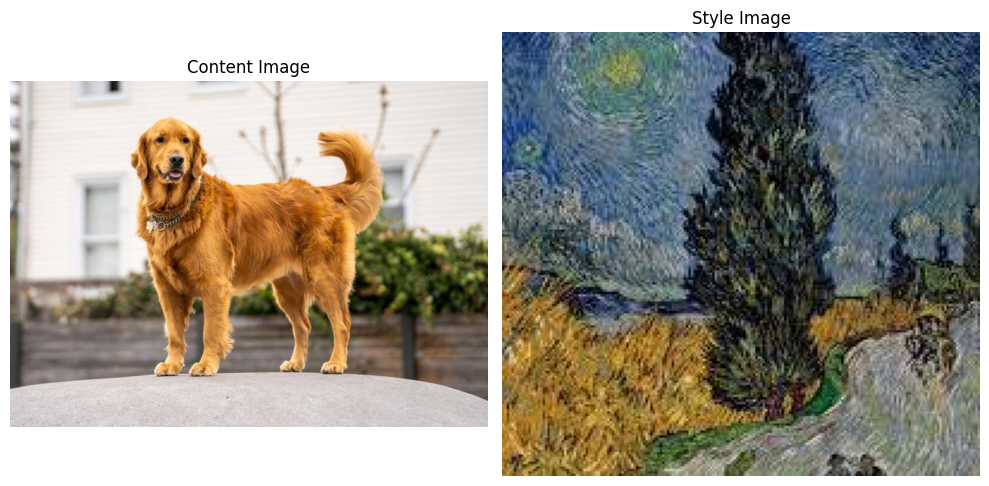

In [ ]:
# Upload content and style images
content_file = files.upload()
style_file = files.upload()

content_image = Image.open(list(content_file.keys())[0]).convert('RGB')
style_image = Image.open(list(style_file.keys())[0]).convert('RGB')

# Display uploaded images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title('Content Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title('Style Image')
plt.axis('off')
plt.tight_layout()
plt.show()


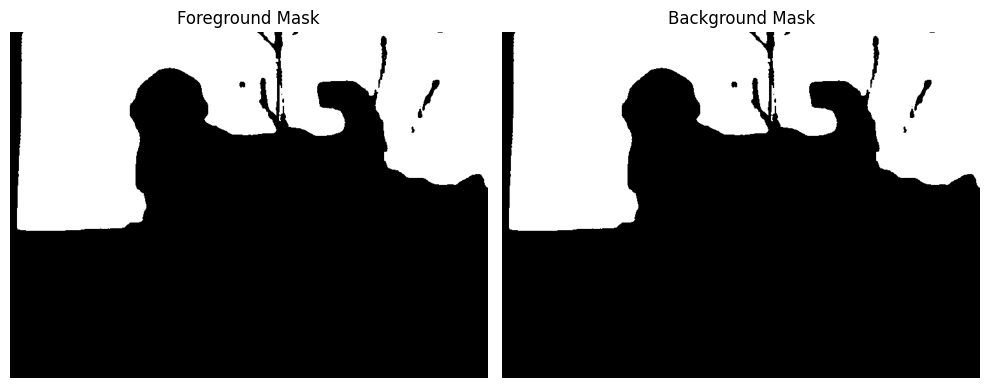

In [ ]:
# Perform segmentation
content_np = np.array(content_image)
sam_result = mask_generator.generate(content_np)
largest_mask = max(sam_result, key=lambda x: x['area'])['segmentation']
foreground_mask = Image.fromarray(largest_mask.astype(np.uint8) * 255)

# Background mask (unchanged, no inversion)
background_mask_np = largest_mask.astype(np.uint8) * 255
background_mask = Image.fromarray(background_mask_np)

# Display masks for verification
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(foreground_mask, cmap='gray')
plt.title('Foreground Mask')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(background_mask, cmap='gray')
plt.title('Background Mask')
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Define preprocessing function
def preprocess_image(image, size=512, is_mask=False):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    if not is_mask:
        transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    return transform(image).unsqueeze(0)

# Load VGG19 model for style transfer
from torchvision.models import vgg19
vgg = vgg19(pretrained=True).features
vgg = vgg.to(device)
vgg.eval()
for param in vgg.parameters():
    param.requires_grad_(False)

# Define style transfer function
def style_transfer(content_img, style_img, mask_img, num_steps=700):
    input_img = content_img.clone().requires_grad_(True)
    optimizer = torch.optim.Adam([input_img], lr=0.02)

    content_layers = ['21']
    style_layers = ['0', '5', '10', '19', '28']
    style_weights = {
        '0': 1.0,
        '5': 0.8,
        '10': 0.5,
        '19': 0.3,
        '28': 0.1
    }

    content_features = get_features(content_img, vgg, content_layers + list(style_weights.keys()))
    style_features = get_features(style_img, vgg, list(style_weights.keys()))

    for step in range(num_steps):
        features = get_features(input_img, vgg, content_layers + list(style_weights.keys()))
        content_l = content_loss(features[content_layers[0]], content_features[content_layers[0]])
        style_l = 0
        for layer, weight in style_weights.items():
            layer_style_loss = style_loss(features[layer], style_features[layer], weight)
            style_l += layer_style_loss
        tv_l = total_variation_loss(input_img)
        total_loss = content_l + 1e6 * style_l + 1e-5 * tv_l

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if (step + 1) % 50 == 0:
            print(f"Step {step + 1}: Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}")

    with torch.no_grad():
        output = input_img * background_mask_tensor + content_img * background_mask_tensor.logical_not()
    return output

# Helper functions for style transfer
def get_features(image, model, layers):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[name] = x
    return features

def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    return torch.mm(tensor, tensor.t())

def content_loss(content_features, target_features):
    return torch.mean((content_features - target_features)**2)

def style_loss(style_features, target_features, weight=1.0):
    gram_style = gram_matrix(style_features)
    gram_target = gram_matrix(target_features)
    return weight * torch.mean((gram_style - gram_target)**2)

def total_variation_loss(image):
    h_tv = torch.mean((image[:,:,1:,:] - image[:,:,:-1,:])**2)
    w_tv = torch.mean((image[:,:,:,1:] - image[:,:,:,:-1])**2)
    return h_tv + w_tv


In [ ]:
# Preprocess images
content_tensor = preprocess_image(content_image).to(device)
style_tensor = preprocess_image(style_image).to(device)
background_mask_tensor = preprocess_image(background_mask, is_mask=True).to(device)

# Perform style transfer
output = style_transfer(content_tensor, style_tensor, background_mask_tensor)


Step 50: Content Loss: 4.9775, Style Loss: 274255232.0000
Step 100: Content Loss: 5.6921, Style Loss: 120448248.0000
Step 150: Content Loss: 6.0197, Style Loss: 67465792.0000
Step 200: Content Loss: 6.2421, Style Loss: 45023480.0000
Step 250: Content Loss: 6.3960, Style Loss: 32279328.0000
Step 300: Content Loss: 6.5217, Style Loss: 24265610.0000
Step 350: Content Loss: 6.6224, Style Loss: 18936612.0000
Step 400: Content Loss: 6.7108, Style Loss: 15249950.0000
Step 450: Content Loss: 6.7808, Style Loss: 12620282.0000
Step 500: Content Loss: 6.8422, Style Loss: 10688135.0000
Step 550: Content Loss: 6.8927, Style Loss: 9222452.0000
Step 600: Content Loss: 6.9389, Style Loss: 8080752.0000
Step 650: Content Loss: 6.9802, Style Loss: 7164779.5000
Step 700: Content Loss: 7.0134, Style Loss: 6413043.5000


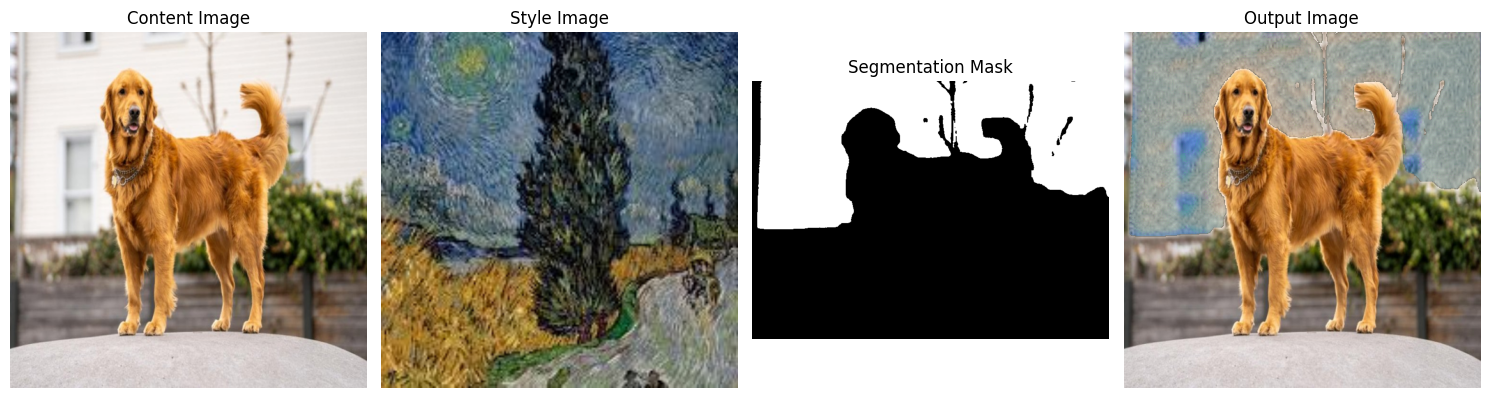

In [ ]:
# Denormalize output image
def denormalize_image(tensor):
    tensor = tensor.cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    tensor = tensor.detach() * 255
    tensor = tensor.numpy().transpose(1, 2, 0).astype(np.uint8)
    return Image.fromarray(tensor)

content_display = denormalize_image(content_tensor.squeeze(0))
style_display = denormalize_image(style_tensor.squeeze(0))
output_display = denormalize_image(output.squeeze(0))

# Display the final output
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(content_display)
plt.title('Content Image')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(style_display)
plt.title('Style Image')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(foreground_mask, cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(output_display)
plt.title('Output Image')
plt.axis('off')
plt.tight_layout()
plt.show()

output_display.save('style_transfer_output.png')
